#### Standart imports, random seed and cuda settings

In [22]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data.sampler import SubsetRandomSampler
import random as rand
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
#import tqdm.notebook as tq
import seaborn as sns
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import os

In [63]:
BASE_PATH='.' 

In [25]:
# use a random seed
import os
import random
def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return
set_random_seed(20)

In [26]:
# set the computing device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Method for saving models

In [28]:
# for saving complete models
def save_model(n_epochs, lr, batch_size, model, loss_hist, eval_hist, hidden_dim1, hidden_dim2, grad_hist):
    savepath = f"{BASE_PATH}/models/model_ne{n_epochs}_lr{lr}_bs{batch_size}_hd2{hidden_dim2}.pth"
    
    torch.save({
        'n_epochs': n_epochs,
        'lr': lr,
        'batch_size': batch_size,
        'model_state_dict': model.state_dict(),
        'loss_hist': loss_hist,
        'eval_hist': eval_hist,
        'hidden_dim1': hidden_dim1,
        'hidden_dim2': hidden_dim2,
        'grad_hist': grad_hist
    }, savepath)

#### Loading data

In [64]:
# load the data
trainvalset = dsets.CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())

indices = list(range(len(trainvalset)))
np.random.shuffle(indices)
train_indices = indices[:40000]
val_indices = indices[40000:]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

def get_train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(trainvalset, batch_size=batch_size, sampler=train_sampler, shuffle=False)
    return train_loader

def get_val_loader(batch_size):
    val_loader = torch.utils.data.DataLoader(trainvalset, batch_size=batch_size, sampler=val_sampler, shuffle=False)
    return val_loader

def get_test_loader(batch_size):
    return torch.utils.data.DataLoader(dataset=testset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Model and training

In [30]:
# define the model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim=3072, hidden_dim1=128, hidden_dim2=48, output_dim=10):
        super().__init__()
        self.input_dim = input_dim
        self.last_layer = nn.Linear(hidden_dim2, output_dim)
        self.layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            self.last_layer
        )        
    
    def forward(self, x):
        x_flat = x.view(-1, self.input_dim)
        out = self.layer(x_flat)
        return out

In [31]:
# training
def train(n_epochs=15, lr=1e-2, learning_curve=True, batch_size=20, prog_bar=True, hidden_dim1=128, hidden_dim2=48):
    n_epochs = int(n_epochs)
    batch_size = int(batch_size)
    train_loader, val_loader = get_train_loader(batch_size), get_val_loader(batch_size)
    
    model = LogisticRegressionModel(hidden_dim1=int(hidden_dim1), hidden_dim2=int(hidden_dim2))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)
    
    loss_hist = []
    eval_hist = []
    grad_hist = [] # the norms of the gradient of the last layers parameters
    
    if not prog_bar:
        print('epoch: ', end='')
    
    for epoch in range(n_epochs):
        grad_list = []
        if prog_bar:
            batches = tqdm(enumerate(train_loader), total=len(train_loader), position=0, leave=True)
        else:
            output = str(epoch+1) + ', '
            print(output, end='')
            batches = enumerate(train_loader)
            
        for i, (imgs, labels) in batches:
            # move imgs and labels to the device we use
            imgs = imgs.to(device)
            x = imgs
            labels = labels.to(device)

            # forward pass
            pred_labels = model(imgs)

            # computing loss
            loss = criterion(pred_labels, labels)
            
            # removing accumulated gradients
            optimizer.zero_grad()
            loss.backward()
            
            if learning_curve:
                # calcualte the norm of the gradient of the last layer
                parameters = model.last_layer.parameters()
                for p in list(filter(lambda p: p.grad is not None, parameters)):
                    grad_list.append(p.grad.data.norm(2).item())
            
            optimizer.step()
            if prog_bar and (i%1 == 0 or i == len(train_loader)-1):
                batches.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")

        # calcualte the loss for the learning curve
        if learning_curve:
            loss_hist.append(get_loss(model, train_loader, criterion, prog_bar))
            eval_hist.append(get_loss(model, val_loader, criterion, prog_bar))
            grad_hist.append(np.mean(grad_list))
        # A quick note: we know that this is kinda redundant and not that good
        # for performance to calculate the loss of the model on the training data
        # by iterating over it once more.
        # But if we use the losses we calculated in the training steps, those are obtained
        # by different weights since the weights get updated every batch.
        # So we decided to recalculate the loss here again in order to it being 
        # comparable to the loss we calculate on the valuation data.
        # We would love to see what best practice here.
            
    save_model(n_epochs, lr, batch_size, model, loss_hist, eval_hist, hidden_dim1, hidden_dim2, grad_hist)
    return model


def get_loss(model, data_loader, criterion, prog_bar):
    """Returns the average loss of this model on the data of the data_loader given the criterion."""
    with torch.no_grad():
        if prog_bar:
            batches = tqdm(enumerate(data_loader), total=len(data_loader), position=0, leave=True)
            batches.set_description('Compute loss')
        else:
            batches = enumerate(data_loader)
        loss_list = []
        for i, (imgs, labels) in batches: 
            imgs = imgs.to(device)
            labels = labels.to(device)

            pred_labels = model(imgs)
            loss = criterion(pred_labels, labels)
            loss_list.append(loss.item())

        return np.mean(loss_list)


In [32]:
def accuracy(model, prog_bar=True, data_loader=get_test_loader(100)):
    n_correct = 0

    with torch.no_grad():
        if prog_bar:
            batches = tqdm(enumerate(data_loader), total=len(data_loader), position=0)
        else:
            batches = enumerate(data_loader)
        for i, (imgs, labels) in batches: 
            #everything needs to be on the same device
            imgs = imgs.to(device)
            labels = labels.to(device)

            # forward pass
            pred_labels = model(imgs)

            preds = torch.argmax(pred_labels, dim=-1)
            cur_correct = len(torch.where(preds == labels)[0])
            n_correct = n_correct + cur_correct
    return n_correct / len(testset)

## Learning curve, gradient curve and evaluation

In [33]:
def show_learning_curve(name):
    path = f"{BASE_PATH}/models/{name}"
    saved_model = torch.load(path,  map_location="cpu")

    lr = saved_model['lr']
    batch_size = saved_model['batch_size']
    n_epochs = saved_model['n_epochs']
    loss_hist = saved_model['loss_hist']
    eval_hist = saved_model['eval_hist']
    print(f"The model used learning rate {lr}, batch size {batch_size} and {n_epochs} epochs.")
    
    try:
        hidden_dim1 = saved_model['hidden_dim1']
        hidden_dim2 = saved_model['hidden_dim2']
        print(f"The dimension of hidden layer 1 was {hidden_dim1}.")
        print(f"The dimension of hidden layer 2 was {hidden_dim2}.")
    except KeyError:
        pass
    print("It achived the following results:")

    x = np.arange(1, len(loss_hist)+1)
    fig, ax = plt.subplots()
    plt.plot(x, eval_hist, label='val loss')
    plt.plot(x, loss_hist, label='train loss')

    plt.grid()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Learning Progress")
    ax.legend()
    plt.show()  

In [34]:
def show_grad_curve(name):
    path = f"{BASE_PATH}/models/{name}"
    saved_model = torch.load(path,  map_location="cpu")

    lr = saved_model['lr']
    batch_size = saved_model['batch_size']
    n_epochs = saved_model['n_epochs']
    grad_hist = saved_model['grad_hist']
    print(f"The model used learning rate {lr}, batch size {batch_size} and {n_epochs} epochs.")
    
    try:
        hidden_dim1 = saved_model['hidden_dim1']
        hidden_dim2 = saved_model['hidden_dim2']
        print(f"The dimension of hidden layer 1 was {hidden_dim1}.")
        print(f"The dimension of hidden layer 2 was {hidden_dim2}.")
    except KeyError:
        pass
    print("The norm of its gradients in the last layer has developed in the following way:")

    x = np.arange(1, len(grad_hist)+1)
    fig, ax = plt.subplots()
    plt.plot(x, grad_hist, label='gradient norm')

    plt.grid()
    plt.xlabel("Epoch")
    plt.ylabel("Gradient norm")
    plt.title("Gradient Norm")
    plt.show()  

## hyperparameter optimization

We now do some experiments to see which hyper parameters to use and later we also use a hyperparameter optimization library for some parameters.

In [ ]:
model_1 = train(n_epochs=20, lr=3e-3, learning_curve=True, batch_size=20, prog_bar=False, hidden_dim1=128, hidden_dim2=48)

epoch: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 

The model used learning rate 0.003, batch size 20 and 20 epochs.
The dimension of hidden layer 1 was 128.
The dimension of hidden layer 2 was 48.
It achived the following results:


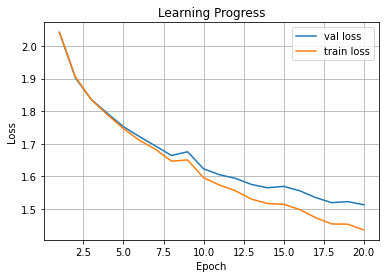

In [ ]:
show_learning_curve('first_runs/model_ne20_lr0.003_bs20.pth') # model_1

In [ ]:
accuracy(model_1, data_loader=get_val_loader(100))

100%|██████████| 100/100 [00:01<00:00, 98.40it/s]


0.4742

It looks as though we could use some more epochs.

In [ ]:
set_random_seed(33)
model_2 = train(n_epochs=35, lr=3e-3, learning_curve=True, batch_size=20, prog_bar=False, hidden_dim1=128, hidden_dim2=48)

epoch: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 

The model used learning rate 0.003, batch size 20 and 35 epochs.
The dimension of hidden layer 1 was 128.
The dimension of hidden layer 2 was 48.
It achived the following results:


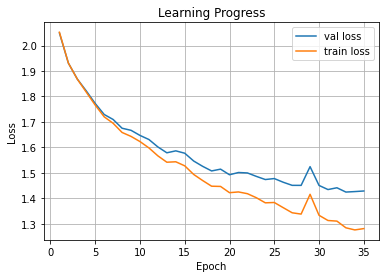

In [ ]:
show_learning_curve('first_runs/model_ne35_lr0.003_bs20.pth') # model_2

In [ ]:
accuracy(model_2, data_loader=get_val_loader(100))

100%|██████████| 100/100 [00:01<00:00, 95.77it/s]


0.4929

Since the model still does get better, we do the same experiment with double the learning rate, to see what happens.

In [ ]:
model_3 = train(n_epochs=35, lr=6e-3, learning_curve=True, batch_size=20, prog_bar=False, hidden_dim1=128, hidden_dim2=48)

epoch: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 

The model used learning rate 0.006, batch size 20 and 35 epochs.
The dimension of hidden layer 1 was 128.
The dimension of hidden layer 2 was 48.
It achived the following results:


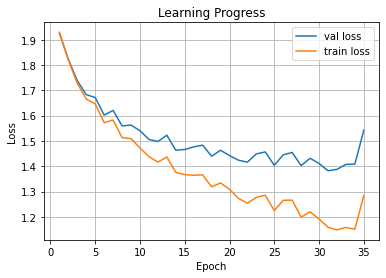

In [ ]:
show_learning_curve('first_runs/model_ne35_lr0.006_bs20.pth') # model_3

In [ ]:
accuracy(model_3, data_loader=get_val_loader(100))

100%|██████████| 100/100 [00:01<00:00, 92.48it/s]


0.4743

As we see, the results were not so good. So our learning rate seems to be reasonable.

Also, the difference of the valuation loss and training loss in the past results was not that low, so we will try again with fewer neurons and more epochs.

In [ ]:
model_4 = train(n_epochs=80, lr=3e-3, learning_curve=True, batch_size=20, prog_bar=False, hidden_dim1=96, hidden_dim2=48)

epoch: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 

The model used learning rate 0.003, batch size 20 and 80 epochs.
The dimension of hidden layer 1 was 96.
The dimension of hidden layer 2 was 48.
It achived the following results:


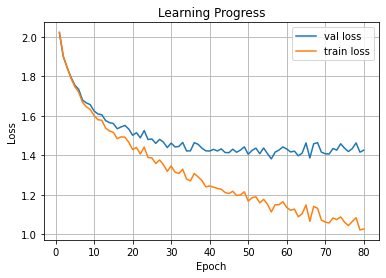

In [ ]:
show_learning_curve('first_runs/model_ne80_lr0.003_bs20.pth') # model_4

In [ ]:
accuracy(model_4, data_loader=get_val_loader(100))

100%|██████████| 100/100 [00:00<00:00, 102.12it/s]


0.5158

The model used learning rate 0.003, batch size 20 and 80 epochs.
The dimension of hidden layer 1 was 96.
The dimension of hidden layer 2 was 48.
The norm of its gradients in the last layer has developed in the following way:


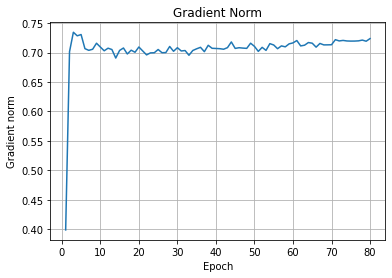

In [ ]:
show_grad_curve('first_runs/model_ne80_lr0.003_bs20.pth') # model_4

As we see, at about 40 epochs, the model does not seem to get better any more.

So 40 epochs seems like a reasonable choice and also our choice for the learning rate seems to be reasonable.

Since we now know a somewhat good number of epochs and learning rate, we use the hyperparameter optimization library hyperopt to optimize the size of the last layer and the batch size. 

In [35]:
trials = Trials()

In [36]:
val_loader = get_val_loader(100)

def accuracy_hyp(space):    
    batch_size = space['batch_size']
    lr = 3e-3
    n_epochs = 40
    hidden_dim1 = 96
    hidden_dim2 = space['hidden_dim2']

    out = f"n_epochs= {n_epochs} batch_size= {batch_size} lr= {lr} hidden_dim1= {hidden_dim1} hidden_dim2= {hidden_dim2}"
    print(out)

    model = train(n_epochs=int(n_epochs), lr=lr, batch_size=int(batch_size), 
                        prog_bar=False, learning_curve=True,
                        hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2)
    return {'loss': (1-accuracy(model, prog_bar=False, data_loader=val_loader)), 'status': STATUS_OK, 'model': model}

space = {
    'batch_size': hp.quniform('batch_size', 5, 40, 1),
    'hidden_dim2': hp.quniform('hidden_dim2', 32, 64, 1)
}

In [18]:
set_random_seed(11)

In [39]:
def save_trials(name):
    savepath = f"{BASE_PATH}/models/{name}"
    torch.save(trials, savepath)

def load_trials(name):
    path = f"{BASE_PATH}/models/{name}"
    return torch.load(path, map_location=torch.device('cpu'))

In [ ]:
# start with 2 trials only
best  = fmin(
    fn=accuracy_hyp,
    space=space,
    algo=tpe.suggest,
    max_evals=2,
    trials=trials
)

save_trials('trials_2.pth')

n_epochs= 40 batch_size= 27.0 lr= 0.003 hidden_dim1= 96 hidden_dim2= 34.0
epoch: 
1, 
2, 
3, 
4, 
5, 
6, 
7, 
8, 
9, 
10, 
11, 
12, 
13, 
14, 
15, 
16, 
17, 
18, 
19, 
20, 
21, 
22, 
23, 
24, 
25, 
26, 
27, 
28, 
29, 
30, 
31, 
32, 
33, 
34, 
35, 
36, 
37, 
38, 
39, 
40, 
n_epochs= 40 batch_size= 13.0 lr= 0.003 hidden_dim1= 96 hidden_dim2= 39.0
epoch: 
1, 
2, 
3, 
4, 
5, 
6, 
7, 
8, 
9, 
10, 
11, 
12, 
13, 
14, 
15, 
16, 
17, 
18, 
19, 
20, 
21, 
22, 
23, 
24, 
25, 
26, 
27, 
28, 
29, 
30, 
31, 
32, 
33, 
34, 
35, 
36, 
37, 
38, 
39, 
40, 
100%|██████████| 2/2 [15:33<00:00, 466.93s/it, best loss: 0.49570000000000003]


In [40]:
set_random_seed(33)
# do another 13 trials
trials = load_trials('trials_2.pth')
best  = fmin(
    fn=accuracy_hyp,
    space=space,
    algo=tpe.suggest,
    max_evals=15,
    trials=trials
)

save_trials('trials_15.pth')

n_epochs= 40 batch_size= 27.0 lr= 0.003 hidden_dim1= 96 hidden_dim2= 49.0
epoch:                                                
1,                                                    
2,                                                    
3,                                                    
4,                                                    
5,                                                    
6,                                                    
7,                                                    
8,                                                    
9,                                                    
10,                                                   
11,                                                   
12,                                                   
13,                                                   
14,                                                   
15,                                                   
16,                                           

In [41]:
best

{'batch_size': 17.0, 'hidden_dim2': 35.0}

As we see, the best batch size according to the algorithm is 17 and the best dimension for hidden layer two is 35.

This seems reasonable, because also in the last plot before useing the library to search for the best hyperparameters, the model somewhat overfits.

We will now train the model with the suggested hyperparameters and look at the results.

In [44]:
set_random_seed(55)
model_5 = train(n_epochs=40, lr=3e-3, learning_curve=True, batch_size=17, prog_bar=False, hidden_dim1=96, hidden_dim2=35)

epoch: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 

The model used learning rate 0.003, batch size 17 and 40 epochs.
The dimension of hidden layer 1 was 96.
The dimension of hidden layer 2 was 35.0.
It achived the following results:


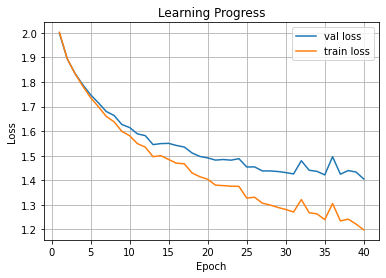

In [46]:
show_learning_curve('model_ne40_lr0.003_bs17_hd235.0.pth')

In [47]:
accuracy(model_5, data_loader=get_val_loader(100))

100%|██████████| 100/100 [00:00<00:00, 132.56it/s]


0.4893

The accuracy is not that high.
Since the model still slightly overfits, we try out another experiment with lower dimension of layer 2 and lower learning rate.

In [48]:
set_random_seed(55)
model_6 = train(n_epochs=40, lr=1.5e-3, learning_curve=True, batch_size=17, prog_bar=False, hidden_dim1=96, hidden_dim2=25)

epoch: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 

The model used learning rate 0.0015, batch size 17 and 40 epochs.
The dimension of hidden layer 1 was 96.
The dimension of hidden layer 2 was 25.
It achived the following results:


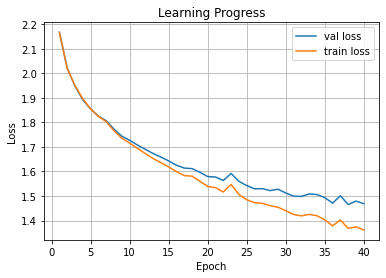

In [49]:
show_learning_curve('model_ne40_lr0.0015_bs17_hd225.pth')

In [50]:
accuracy(model_6, data_loader=get_val_loader(100))

100%|██████████| 100/100 [00:00<00:00, 128.72it/s]


0.4855

The Accuracy in this experiment is worse, so maybe the result of the algorithm was not that bad after all.

So as a final result we take model_5 which we trained on the following parameters:

n_epochs=40, 
lr=3e-3, 
batch_size=17, 
hidden_dim1=96 and
hidden_dim2=35

The norm of the gradient of the last layer from this model is the following:

The model used learning rate 0.003, batch size 17 and 40 epochs.
The dimension of hidden layer 1 was 96.
The dimension of hidden layer 2 was 35.0.
The norm of its gradients in the last layer has developed in the following way:


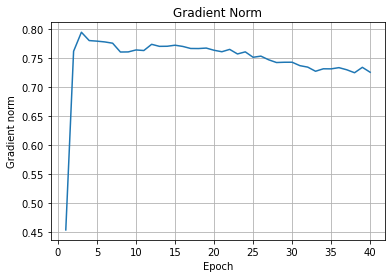

In [57]:
show_grad_curve('model_ne40_lr0.003_bs17_hd235.0.pth')

The accuracy on the test-data is 48.89% as we can see here:

In [56]:
accuracy(model_5)

100%|██████████| 100/100 [00:00<00:00, 130.73it/s]


0.4889

## Confusion matrix

Now we also want to analyze the confusion matrix.

In [61]:
def confusion_matrix(name, data_loader=get_val_loader(100)):
    path = f"{BASE_PATH}/models/{name}"
    saved_model = torch.load(path,  map_location="cpu")

    lr = saved_model['lr']
    batch_size = int(saved_model['batch_size'])
    n_epochs = int(saved_model['n_epochs'])
    loss_hist = saved_model['loss_hist']
    eval_hist = saved_model['eval_hist']
    hidden_dim1 = int(saved_model['hidden_dim1'])
    hidden_dim2 = int(saved_model['hidden_dim2'])

    model=LogisticRegressionModel(hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2).to(device)
    model.load_state_dict(saved_model['model_state_dict'])

    print(f"The model used learning rate {lr}, batch size {batch_size} and {n_epochs} epochs.")
    print("It has the following confusion matrix:")

    n_correct = 0
    confusion_matrix = np.zeros((10,10), dtype=int)

    with torch.no_grad():
      progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), position=0)
      for i, (imgs, labels) in progress_bar: 
          #everything needs to be on the same device
          imgs = imgs.to(device)
          labels = labels.to(device)

          # forward pass
          pred_labels = model(imgs)

          preds = torch.argmax(pred_labels, dim=-1)
          for p, l in zip(preds, labels):
              confusion_matrix[int(l), int(p)] += 1

    sns.heatmap(confusion_matrix,
              xticklabels=testset.classes, yticklabels=testset.classes, annot=True, fmt='d')

 11%|█         | 11/100 [00:00<00:00, 106.40it/s]

The model used learning rate 0.003, batch size 17 and 40 epochs.
It has the following confusion matrix:


100%|██████████| 100/100 [00:00<00:00, 125.03it/s]


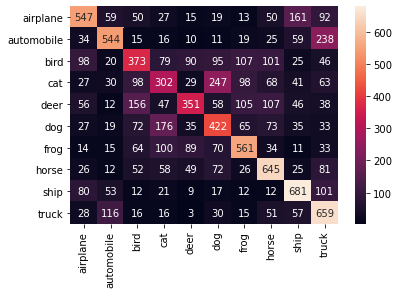

In [62]:
confusion_matrix("model_ne40_lr0.003_bs17_hd235.0.pth")

The rows are the true labels and the columns are the predicted labels.

As we can see, most often, cats are misclassified as dogs and automobiles are misclassified as trucks.

Both of those observations are reasonable.